## Vehicle detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

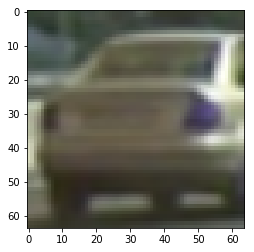

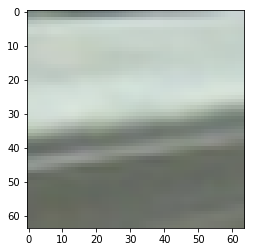

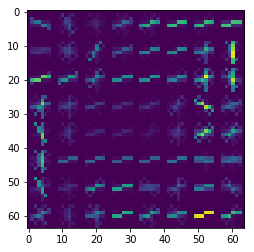

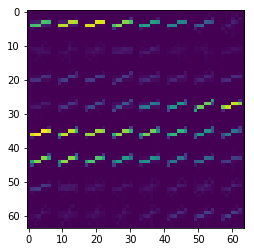

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage.feature import hog as sk_hog

PIX_PER_CELL=8

def gray(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def hog(image, pix_per_cell = PIX_PER_CELL, cell_per_block = 2, orient = 9, vis = False, fvect=True):
    if (vis):
        features, hog_image = sk_hog(image, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=fvect,transform_sqrt=True,
                          block_norm="L2-Hys")
        return features, hog_image
    else:
        features = sk_hog(image, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=fvect,transform_sqrt=True,
                          block_norm="L2-Hys")
        return features


def hog_gray(img):
    return hog(gray(img))

def hog_imread(img):
    return hog_gray(cv2.imread(img))
    
origin = cv2.imread("examples/image0009.png")
origin2 = cv2.imread("examples/image1011.png")

features, image = hog(gray(origin), vis=True)
features2, image2 = hog(gray(origin2), vis=True)


plt.imshow(origin)
plt.show()
plt.imshow(origin2)
plt.show()

plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()

In [2]:
def color_hists(img):
    R = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    G = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    B = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    return np.concatenate((R[0],G[0],B[0]))

def s_hist(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = np.histogram(hsv[:,:,0], bins=32, range=(0, 256))
    S = np.histogram(hsv[:,:,1], bins=32, range=(0, 256))
    V = np.histogram(hsv[:,:,2], bins=32, range=(0, 256))
    return np.concatenate((H[0], S[0], V[0]))
    
def spatial_bin(img):
    return cv2.resize(img, (8, 8)).ravel()

In [3]:
def hogs(img, fvect=True):
    imgs = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
    hg1 = hog(imgs[:,:,0], fvect=fvect)
    hg2 = hog(imgs[:,:,1], fvect=fvect)
    hg3 = hog(imgs[:,:,2], fvect=fvect)
    return(hg1, hg2, hg3)

def all_hist(img):
    col = color_hists(img)
    spat = spatial_bin(img)
    s= s_hist(img)
    ycr = color_hists(cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb))
    luv = color_hists(cv2.cvtColor(img,cv2.COLOR_BGR2LUV))
    return(col, spat, s, ycr, luv)
def all_img(img):
    hg1, hg2, hg3 = hogs(img)
    col, spat, s , ycr, luv= all_hist(img)
    out = np.concatenate((hg1, hg2, hg3, col, spat, s, ycr, luv))
    return out

def all_imread(pth):
    return (all_img(cv2.imread(pth)))

In [4]:
from sklearn.preprocessing import StandardScaler

def normalize(X):
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    return (X_scaler.transform(X), X_scaler)

In [5]:
feature1, feature2 = all_img(origin), all_img(origin2)
feature_list = [feature1, feature2, feature2,feature1, feature2, feature2]
print(feature1.shape)
# Create an array stack, NOTE: StandardScaler() expects np.float64
X = np.vstack(feature_list).astype(np.float64)

#(scaled_t, scaler_t)=normalize(X)



(5868,)


In [6]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import glob
from sklearn.utils import shuffle
from multiprocessing import Pool, Process

images1 = glob.glob('training/vehicles/*/*.png')
images2 = glob.glob('training/non-vehicles/*/*.png')


feat = []
ress =[]





In [ ]:
pool = Pool(2)
#for img in images1:
#    feat.append(hog(gray(cv2.imread(img))))
#    ress.append (1)
ress = [1]*len(images1) + [0]*len(images2)
feat = pool.map_async(all_imread, images1)



#for img in images2:
#    feat.append(hog(gray(cv2.imread(img))))
#    ress.append (0)


In [ ]:
pool2 = Pool(2)
feat2 = pool2.map_async(all_imread, images2)
pool.close()
pool.join()
pool2.close()
pool2.join()
feats1=  feat.get()
feats2= feat2.get()
feats=feats1 + feats2

In [ ]:
feats, ress = shuffle (feats, ress)
    
X = np.vstack(feats).astype(np.float64)

scaled, scaler = normalize(X)


In [ ]:
for (num, img) in enumerate([origin, origin2]):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[num])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled[num])
    plt.title('Normalized Features')
    fig.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
#clf = GridSearchCV(svr, parameters)
#clf.fit(X, ress)
tx, testx, ty, testy =  train_test_split(scaled, ress)

In [ ]:
clf_scaled = RandomizedSearchCV(svr, parameters, n_iter=4, n_jobs=4)
clf_scaled.fit(tx, ty)

In [ ]:
e=clf_scaled.predict (testx)
#pred =c==ress
pred2 = e == testy
n=0
#for num, i in enumerate(pred):
#    if not i:
#        print (c[num])
#        n+=1
#accuracy = ((len(ress)-n)/len(ress))
#print(accuracy)
for num, i in enumerate(pred2):
    if not i:
        print (e[num])
        n+=1
accuracy = ((len(ress)-n)/len(ress))
print(accuracy)

In [ ]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), y_factor=1, xy_overlap=(0.5, 0.5), scale=1):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    y=1
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = (xs*nx_pix_per_step + x_start_stop[0])/y
            endx = (startx + xy_window[0])*y
            starty = (ys*ny_pix_per_step + y_start_stop[0])/y
            endy = (starty + xy_window[1])*y
            # Append window position to list
            window_list.append(((int(startx), int(starty)), (int(endx), int(endy)), scale))
        y*=y_factor
    # Return the list of windows
    return window_list
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [ ]:
image = cv2.imread('test_images/test1.jpg')
#image = cv2.imread('orig176.png')

lis=slide_window(image, y_start_stop = [400, 600], xy_window = (64,64), xy_overlap = (0.5,0.5),y_factor=1, scale=1)
lis+=slide_window(image, y_start_stop = [400, 500], xy_window = (32,32), xy_overlap = (0.5,0.5),y_factor=1, scale=0)
lis+=slide_window(image, y_start_stop = [400, 700], xy_window = (96,96), xy_overlap = (0.5,0.5),y_factor=1, scale=2)

lis+=slide_window(image, y_start_stop = [350, image.shape[0]], xy_window = (128,128), xy_overlap = (0.8,0.8),y_factor=1, scale=3)



img = draw_boxes(image, lis, color=(0, 0, 255), thick=6)
plt.imshow(img)
plt.show()


In [ ]:
def search_windows(img, windows, scaler, clf_scaled, pix_per_cell=PIX_PER_CELL):
    #, clf, scaler, color_space='RGB', 
    #                spatial_size=(32, 32), hist_bins=32, 
    #                hist_range=(0, 256), orient=9, 
    #                pix_per_cell=8, cell_per_block=2, 
    #                hog_channel=0, spatial_feat=True, 
    #                hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    #hog_images = [hogs(img)] + [hogs(img)] + [hogs(img)] + [hogs(img)]
    hs=[hogs(img, fvect=False),
        hogs(cv2.resize(img, (int(img.shape[1]/2), int(img.shape[0]/2))), fvect=False),
        hogs(cv2.resize(img, (int(img.shape[1]/3), int(img.shape[0]/3))), fvect=False), 
        hogs(cv2.resize(img, (int(img.shape[1]/4), int(img.shape[0]/4))), fvect=False)]
    #print(img.shape)
    #print(np.array(hs[0]).shape)
    #print(np.array(hs[1]).shape)
    #print(np.array(hs[2]).shape)
    #print(np.array(hs[0]).shape)
    #print(np.array(hogs(img[0:64, 0:64])).shape)
    #print(np.array(hs[0])[:,0:3, 0:3].ravel().shape)
    #print(windows[1][2])
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        #features = hogs(test_img)
        #print(int((window[0][1])/4))
        #print(int((window[1][1]-1)/4))
        x_start=int(window[0][1]/pix_per_cell/(2**window[2]))
        y_start=int(window[0][0]/pix_per_cell/(2**window[2]))
        #print(window[0][1], x_start)
        #print(window[0][0], y_start)
        c_end=int(64/pix_per_cell)-1
        
        hg_feats=np.array(hs[window[2]])[:,x_start:x_start+c_end, y_start:y_start+c_end].ravel()
        #print(hg_feats.shape)
        hist_feats=np.concatenate(all_hist(test_img))
        #print(hist_feats.shape)
        #features=all_img(test_img)
        #features=np.array(hs[window[2]])[:,int(window[0][1])/4:int((window[1][1]-1)/4),
        #                       int(window[0][0]/4):int((window[1][0]-1)/4)].ravel()
        features =  np.concatenate([np.array(hg_feats), np.array(hist_feats)])
        #features = np.concatenate([hg_feats, np.array(all_hist(test_img)).ravel()])
        #features = np.concatenate(features)

        #features=np.concatenate(features)
        #5) Scale extracted features to be fed to classifier
        #test_features = scaler.transform(np.array(features).reshape(1, -1))
        try:

            scaled = scaler.transform(features)
        #6) Predict using your classifier
            prediction = clf_scaled.predict(scaled)
        #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
        except:
            pass
    #8) Return windows for positive detections
    return on_windows

In [ ]:
chosen_win = search_windows(image, lis, scaler, clf_scaled)

In [ ]:
img = draw_boxes(image, chosen_win,  color=(0, 0, 255), thick=6)
plt.imshow(img)
plt.show()

In [ ]:
def add_heat(img, bbox_list):
    # Iterate through list of bboxes
    heatmap = np.zeros_like(img)
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
def thresh(img, threshold):
    img[img <= threshold]=0
    return img

In [ ]:
heat = add_heat(img, chosen_win)
plt.imshow(heat*50)
plt.show()

In [ ]:
from scipy.ndimage.measurements import label
tr = thresh(heat, 2)
lab = label(tr)
print(lab[1])
plt.imshow(lab[0].astype(np.uint8)*50)
plt.show()

In [ ]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [ ]:
boxes = draw_labeled_bboxes(image, lab)
plt.imshow(boxes)
plt.show()

In [ ]:
# 1 HOG attempt

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1, hog2, hog3 = hogs(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    print(np.array(hog1).shape)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    

In [ ]:
from random import randint

oldheat=[]
def process_image(image):
    global oldheat
    chosen_win = search_windows(image, lis, scaler, clf_scaled)
    heat = add_heat(image, chosen_win)
    if (oldheat !=[]):
        heat+=(np.uint8(heat/2))
    #plt.imshow(heat)
    #plt.show()
    tr = thresh(heat, 2)
    #cv2.imwrite("heat"+str(randint(0,1000))+".png", heat)
    #cv2.imwrite("orig"+str(randint(0,1000))+".png", image)

    lab = label(tr)

    oldheat = heat
    drw =  draw_labeled_bboxes(image, lab)
    #cv2.imwrite("drw"+str(randint(0,1000))+".png", drw)

    #plt.show(drw)
    #plt.show()
    return drw


In [ ]:
image = cv2.imread('orig176.png')
ou=process_image(image)
plt.imshow(ou)
plt.show()

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_video(input_vid, output_vid):
    global oldheat
    oldheat = []
    clip1 = VideoFileClip(input_vid)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_vid, audio=False)

In [ ]:
process_video('test_video.mp4', 'out/test_video.mp4')

In [ ]:
process_video('project_video.mp4', 'out/project_video.mp4')